# [문제 1]

### [문제1] g_crypto_currency_regression_train_lstm.py

In [33]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

# 주피터 노트북 환경에 맞는 BASE_PATH 설정
BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 기준으로 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset


def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  # print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape, "!!! - 1")

  # X_train.shape: [3212, 10, 5]
  # X_validation.shape: [100, 10, 5]
  # X_test.shape: [10, 10, 5]
  # y_train.shape: [3212]
  # y_validation.shape: [100]
  # y_test.shape: [10]

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_1-1_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
    # 명령줄 인자 대신 Args 클래스를 사용
    class Args:
        wandb = True
        batch_size = 2048
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 0.0
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6

    args = Args()
    wandb.finish()
    # 기존 main 함수에 args를 직접 전달
    main(args)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 9.45733, V_loss: 73.28746, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.022
[Epoch  30] T_loss: 5.44475, V_loss: 41.66186, V_loss decreased (73.28746 --> 41.66186). Saving model... | T_time: 00:00:01, T_speed: 0.080
[Epoch  60] T_loss: 0.69961, V_loss: 11.37995, V_loss decreased (41.66186 --> 11.37995). Saving model... | T_time: 00:00:02, T_speed: 0.077
[Epoch  90] T_loss: 0.30508, V_loss: 5.47528, V_loss decreased (11.37995 --> 5.47528). Saving model... | T_time: 00:00:04, T_speed: 0.594
[Epoch 120] T_loss: 0.20274, V_loss: 3.17586, V_loss decreased (5.47528 --> 3.17586). Saving model... | T_time: 00:00:05, T_speed: 0.326
[Epoch 150] T_loss: 0.14810, V_loss: 2.00899, V_loss decreased (3.17586 --> 2.00899). Saving model... | T_time: 00:00:06, T_speed: 0.202
[Epoch 

[Epoch 1890] T_loss: 0.01322, V_loss: 0.33845, Early stopping counter: 30 out of 30 *** TRAIN EARLY STOPPED! *** | T_time: 00:01:25, T_speed: 2.094
Final training time: 00:01:25


Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
Training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▂▇▁▁▂▁▁▂▂▂▂▂▃▂▂▂▂▃▂▆▂▂▄▂▂▄▃▂█▃▂▃▂▂▄▂
Validation loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,1890
Training loss,0.01322
Training speed (epochs/sec.),2.09383
Validation loss,0.33845


### [문제1] h_crypto_currency_regression_test_lstm.py

MODEL FILE: /home/work/HW4/checkpoints/lstm_regression_btc_1-1_krw_checkpoint_latest.pt
[TEST DATA]
 0: 950.95 <--> 1,380.87 (Loss:        429.92)
 1: 950.46 <--> 1,319.45 (Loss:        368.98)
 2: 952.34 <--> 1,360.09 (Loss:        407.75)
 3: 951.75 <--> 1,373.29 (Loss:        421.54)
 4: 952.23 <--> 1,302.60 (Loss:        350.37)
 5: 952.25 <--> 1,334.58 (Loss:        382.33)
 6: 951.33 <--> 1,390.43 (Loss:        439.10)
 7: 952.31 <--> 1,284.38 (Loss:        332.07)
 8: 952.28 <--> 1,331.62 (Loss:        379.34)
 9: 952.05 <--> 1,378.05 (Loss:        426.00)


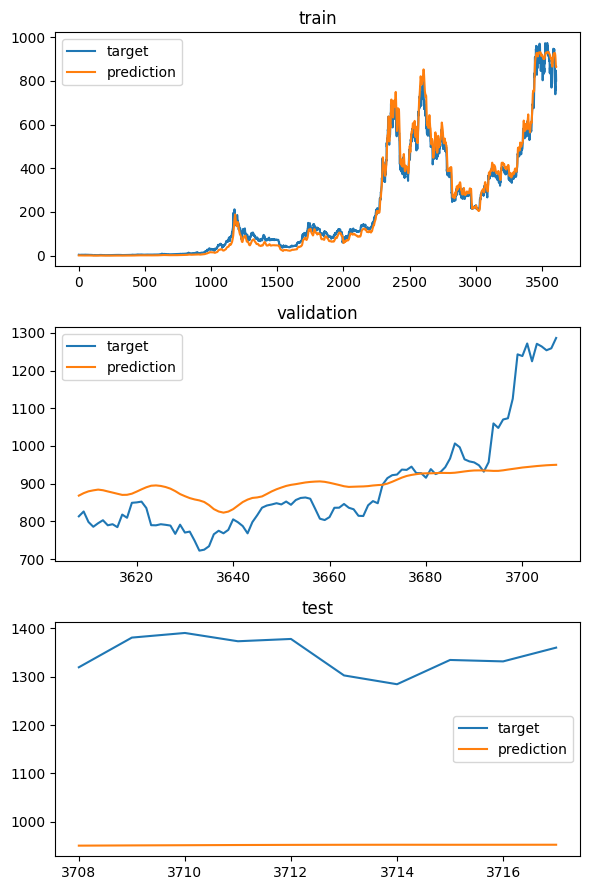

In [37]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 기준으로 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_1-1_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_1-1_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
    # 명령줄 인자 대신 Args 클래스를 사용
    class Args:
        wandb = True
        batch_size = 2048
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 0.0
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6

    args = Args()

    main(args)

### [문제1] i_crypto_currency_classification_train_lstm.py

In [35]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 기준으로 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data

def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_1-2_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.get('weight_decay', 0.0))

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()

if __name__ == "__main__":
    # 명령줄 인자 대신 Args 클래스를 사용
    class Args:
        wandb = True
        batch_size = 2048
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 0.0
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6

    args = Args()
    # 기존 main 함수에 args를 직접 전달
    main(args)

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69212, T_accuracy: 52.7993 | V_loss: 0.68954, V_accuracy: 56.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69048, T_accuracy: 53.2982 | V_loss: 0.69877, V_accuracy: 44.0000 | Early stopping counter: 1 out of 30 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69038, T_accuracy: 52.9933 | V_loss: 0.69784, V_accuracy: 44.0000 | Early stopping counter: 2 out of 30 | T_time: 00:00:02, T_speed: 30.000
[Epoch  90] T_loss: 0.69053, T_accuracy: 52.9933 | V_loss: 0.69844, V_accuracy: 44.0000 | Early stopping counter: 3 out of 30 | T_time: 00:00:04, T_speed: 22.500
[Epoch 120] T_loss: 0.69062, T_accuracy: 53.0488 | V_loss: 0.69826, V_accuracy: 44.0000 | Early stopping counter: 4 out of 30 | T_time: 00:00:05, T_speed: 24.000
[Epoch 150] T_loss: 0.69068, 

### [문제1] j_crypto_currency_classification_test_lstm.py

In [36]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 기준으로 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
from _01_code._15_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model

def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_1-2_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)

if __name__ == "__main__":
    # 명령줄 인자 대신 Args 클래스를 사용
    class Args:
        wandb = True
        batch_size = 2048
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 0.0
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6

    args = Args()

    # 기존 main 함수에 args를 직접 전달
    main(args)

MODEL FILE: /home/work/HW4/checkpoints/lstm_classification_btc_1-2_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 70.000%
 0:   0.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   0.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   0.00
 8:   0.00 <-->   1.00
 9:   0.00 <-->   0.00


# [문제 2]

### [문제2] g_crypto_currency_regression_train_lstm.py

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 기준으로 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
    CryptoCurrencyDataset


# 데이터 로딩 함수
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = \
        get_cryptocurrency_data(
            sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
            target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
        )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader


# 모델 정의 함수
def get_model(n_lstm_layers=2, n_linear_layers=1, dropout_rate=0.3):
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=n_lstm_layers, batch_first=True, dropout=dropout_rate)
            
            # 다중 Linear Layer 추가
            self.linear_layers = nn.Sequential(
                *[nn.Linear(128 if i == 0 else 64, 64 if i < n_linear_layers - 1 else n_output) for i in range(n_linear_layers)]
            )

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # x.shape: [batch_size, 128]
            x = self.linear_layers(x)
            return x

    return MyModel(n_input=5, n_output=1)


# 메인 학습 루프
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
        'n_lstm_layers': args.n_lstm_layers,
        'n_linear_layers': args.n_linear_layers,
        'dropout_rate': args.dropout_rate
    }

    print("Config before wandb.init:", config)

    project_name = "lstm_regression_btc_2-1_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="Experiment with LSTM layers and dropout",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )
    print(f"Wandb initialized: {wandb.run is not None}")
    print(f"Wandb mode: {wandb.run.mode if wandb.run else 'No run'}")
    print(f"Wandb URL: {wandb.run.url if wandb.run else 'No URL'}")
    # 수동 업데이트
    wandb.config.update({
        'weight_decay': args.weight_decay,
        'n_lstm_layers': args.n_lstm_layers,
        'n_linear_layers': args.n_linear_layers,
        'dropout_rate': args.dropout_rate
    }, allow_val_change=True)
    
    print(f"Wandb mode: {wandb.run.mode}")

    print("Wandb config after init:", wandb.config)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model(
        n_lstm_layers=wandb.config.n_lstm_layers,
        n_linear_layers=wandb.config.n_linear_layers,
        dropout_rate=wandb.config.dropout_rate
    )
    model.to(device)

    optimizer = optim.Adam(
        model.parameters(),
        lr=wandb.config.learning_rate,
        weight_decay=wandb.config.weight_decay
    )

    regression_trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    regression_trainer.train_loop()

    wandb.finish()

if __name__ == "__main__":
    class Args:
        wandb = True
        batch_size = 512
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 1e-3 # 0.0, 1e-5, 1e-4, 1e-3
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6
        n_lstm_layers = 1 # LSTM 레이어 개수 설정 기본 1 2, 3, 4
        n_linear_layers = 2  # Linear 레이어 개수 설정 기본 1,2 (3)
        dropout_rate = 0.0  # Dropout rate 설정 기본 0.1, 0.3, 0.5

    args = Args()
    wandb.finish()
    main(args)

Config before wandb.init: {'epochs': 10000, 'batch_size': 512, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.001, 'n_lstm_layers': 1, 'n_linear_layers': 2, 'dropout_rate': 0.0}


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alstjr7141 (alstjr7141-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


wandb: WARNING The mode property of wandb.run is deprecated and will be removed in a future release.


Wandb initialized: True
Wandb mode: run
Wandb URL: https://wandb.ai/alstjr7141-korea-university-of-technology-and-education/lstm_regression_btc_2-1_krw/runs/5mwn47yv
Wandb mode: run
Wandb config after init: {'epochs': 10000, 'batch_size': 512, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.001, 'n_lstm_layers': 1, 'n_linear_layers': 2, 'dropout_rate': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 8.99455, V_loss: 71.54549, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.004
[Epoch  30] T_loss: 0.18160, V_loss: 2.02724, V_loss decreased (71.54549 --> 2.02724). Saving model... | T_time: 00:00:01, T_speed: 0.040
[Epoch  60] T_loss: 0.05391, V_loss: 0.24498, V_loss decreased (2.02724 --> 0.24498). Saving model... | T_time: 00:00:03, T_speed: 0.497
[Epoch  90] T_loss: 0.04031, V_loss: 0.19792, V_loss decreased (0.24498 --> 0.19792). Saving model... | T_time: 00:00:04, T_speed: 0.178
[Epoch 120] T_lo

[Epoch 1770] T_loss: 0.01194, V_loss: 0.05487, Early stopping counter: 1 out of 30 | T_time: 00:01:25, T_speed: 2.667
[Epoch 1800] T_loss: 0.01200, V_loss: 0.05458, V_loss decreased (0.05479 --> 0.05458). Saving model... | T_time: 00:01:27, T_speed: 48.497
[Epoch 1830] T_loss: 0.01196, V_loss: 0.05546, Early stopping counter: 1 out of 30 | T_time: 00:01:28, T_speed: 3.081
[Epoch 1860] T_loss: 0.01185, V_loss: 0.05501, Early stopping counter: 2 out of 30 | T_time: 00:01:29, T_speed: 1.927
[Epoch 1890] T_loss: 0.01242, V_loss: 0.05749, Early stopping counter: 3 out of 30 | T_time: 00:01:31, T_speed: 5.795
[Epoch 1920] T_loss: 0.01179, V_loss: 0.05468, Early stopping counter: 4 out of 30 | T_time: 00:01:32, T_speed: 2.267
[Epoch 1950] T_loss: 0.01180, V_loss: 0.05423, V_loss decreased (0.05458 --> 0.05423). Saving model... | T_time: 00:01:34, T_speed: 9.245
[Epoch 1980] T_loss: 0.01223, V_loss: 0.05642, Early stopping counter: 1 out of 30 | T_time: 00:01:35, T_speed: 2.705
[Epoch 2010] T_

[Epoch 3780] T_loss: 0.01119, V_loss: 0.05289, Early stopping counter: 7 out of 30 | T_time: 00:03:01, T_speed: 3.952
[Epoch 3810] T_loss: 0.01135, V_loss: 0.05188, V_loss decreased (0.05200 --> 0.05188). Saving model... | T_time: 00:03:03, T_speed: 11.415
[Epoch 3840] T_loss: 0.01127, V_loss: 0.05181, V_loss decreased (0.05188 --> 0.05181). Saving model... | T_time: 00:03:04, T_speed: 5.312
[Epoch 3870] T_loss: 0.01128, V_loss: 0.05249, Early stopping counter: 1 out of 30 | T_time: 00:03:06, T_speed: 14.408
[Epoch 3900] T_loss: 0.01132, V_loss: 0.05179, V_loss decreased (0.05181 --> 0.05179). Saving model... | T_time: 00:03:07, T_speed: 6.118
[Epoch 3930] T_loss: 0.01119, V_loss: 0.05360, Early stopping counter: 1 out of 30 | T_time: 00:03:09, T_speed: 21.913
[Epoch 3960] T_loss: 0.01122, V_loss: 0.05373, Early stopping counter: 2 out of 30 | T_time: 00:03:10, T_speed: 7.065
[Epoch 3990] T_loss: 0.01134, V_loss: 0.05319, Early stopping counter: 3 out of 30 | T_time: 00:03:11, T_speed:

[Epoch 5790] T_loss: 0.01117, V_loss: 0.05053, V_loss decreased (0.05061 --> 0.05053). Saving model... | T_time: 00:04:38, T_speed: 12.899
[Epoch 5820] T_loss: 0.01110, V_loss: 0.05047, V_loss decreased (0.05053 --> 0.05047). Saving model... | T_time: 00:04:39, T_speed: 5.976
[Epoch 5850] T_loss: 0.01094, V_loss: 0.05048, Early stopping counter: 1 out of 30 | T_time: 00:04:41, T_speed: 17.200
[Epoch 5880] T_loss: 0.01098, V_loss: 0.05047, Early stopping counter: 2 out of 30 | T_time: 00:04:42, T_speed: 6.876
[Epoch 5910] T_loss: 0.01099, V_loss: 0.05051, Early stopping counter: 3 out of 30 | T_time: 00:04:44, T_speed: 28.399
[Epoch 5940] T_loss: 0.01096, V_loss: 0.05034, V_loss decreased (0.05047 --> 0.05034). Saving model... | T_time: 00:04:45, T_speed: 10.683
[Epoch 5970] T_loss: 0.01098, V_loss: 0.05037, Early stopping counter: 1 out of 30 | T_time: 00:04:47, T_speed: 95.209
[Epoch 6000] T_loss: 0.01096, V_loss: 0.05158, Early stopping counter: 2 out of 30 | T_time: 00:04:48, T_spee

[Epoch 7800] T_loss: 0.01091, V_loss: 0.04961, Early stopping counter: 2 out of 30 | T_time: 00:06:14, T_speed: 19.299
[Epoch 7830] T_loss: 0.01086, V_loss: 0.04990, Early stopping counter: 3 out of 30 | T_time: 00:06:15, T_speed: 8.257
[Epoch 7860] T_loss: 0.01094, V_loss: 0.04948, V_loss decreased (0.04953 --> 0.04948). Saving model... | T_time: 00:06:17, T_speed: 23.961
[Epoch 7890] T_loss: 0.01087, V_loss: 0.04966, Early stopping counter: 1 out of 30 | T_time: 00:06:18, T_speed: 11.155
[Epoch 7920] T_loss: 0.01109, V_loss: 0.04950, Early stopping counter: 2 out of 30 | T_time: 00:06:20, T_speed: 30.019
[Epoch 7950] T_loss: 0.01088, V_loss: 0.05353, Early stopping counter: 3 out of 30 | T_time: 00:06:21, T_speed: 12.481
[Epoch 7980] T_loss: 0.01110, V_loss: 0.05100, Early stopping counter: 4 out of 30 | T_time: 00:06:23, T_speed: 45.380
[Epoch 8010] T_loss: 0.01109, V_loss: 0.05224, Early stopping counter: 5 out of 30 | T_time: 00:06:24, T_speed: 14.713
[Epoch 8040] T_loss: 0.01117,

[Epoch 9810] T_loss: 0.01093, V_loss: 0.04889, V_loss decreased (0.04897 --> 0.04889). Saving model... | T_time: 00:08:00, T_speed: 10.898
[Epoch 9840] T_loss: 0.01077, V_loss: 0.04892, Early stopping counter: 1 out of 30 | T_time: 00:08:02, T_speed: 15.640
[Epoch 9870] T_loss: 0.01082, V_loss: 0.04892, Early stopping counter: 2 out of 30 | T_time: 00:08:04, T_speed: 20.057
[Epoch 9900] T_loss: 0.01080, V_loss: 0.05029, Early stopping counter: 3 out of 30 | T_time: 00:08:06, T_speed: 52.382
[Epoch 9930] T_loss: 0.01093, V_loss: 0.04882, V_loss decreased (0.04889 --> 0.04882). Saving model... | T_time: 00:08:08, T_speed: 146.032
[Epoch 9960] T_loss: 0.01092, V_loss: 0.05047, Early stopping counter: 1 out of 30 | T_time: 00:08:09, T_speed: 18.740
[Epoch 9990] T_loss: 0.01114, V_loss: 0.05122, Early stopping counter: 2 out of 30 | T_time: 00:08:10, T_speed: 11.185
Final training time: 00:08:11


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇█████
Training loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▇▂▁
Validation loss,█▇▆▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,9990
Training loss,0.01114
Training speed (epochs/sec.),11.18507
Validation loss,0.05122


### [문제2] h_crypto_currency_regression_test_lstm.py

MODEL FILE: /home/work/HW4/checkpoints/lstm_regression_btc_2-1_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,210.69 <--> 1,373.29 (Loss:        162.60)
 1: 1,149.07 <--> 1,319.45 (Loss:        170.38)
 2: 1,157.60 <--> 1,334.58 (Loss:        176.98)
 3: 1,176.95 <--> 1,284.38 (Loss:        107.43)
 4: 1,196.81 <--> 1,390.43 (Loss:        193.62)
 5: 1,207.47 <--> 1,378.05 (Loss:        170.57)
 6: 1,182.71 <--> 1,360.09 (Loss:        177.39)
 7: 1,206.89 <--> 1,302.60 (Loss:         95.71)
 8: 1,179.59 <--> 1,331.62 (Loss:        152.03)
 9: 1,165.20 <--> 1,380.87 (Loss:        215.67)


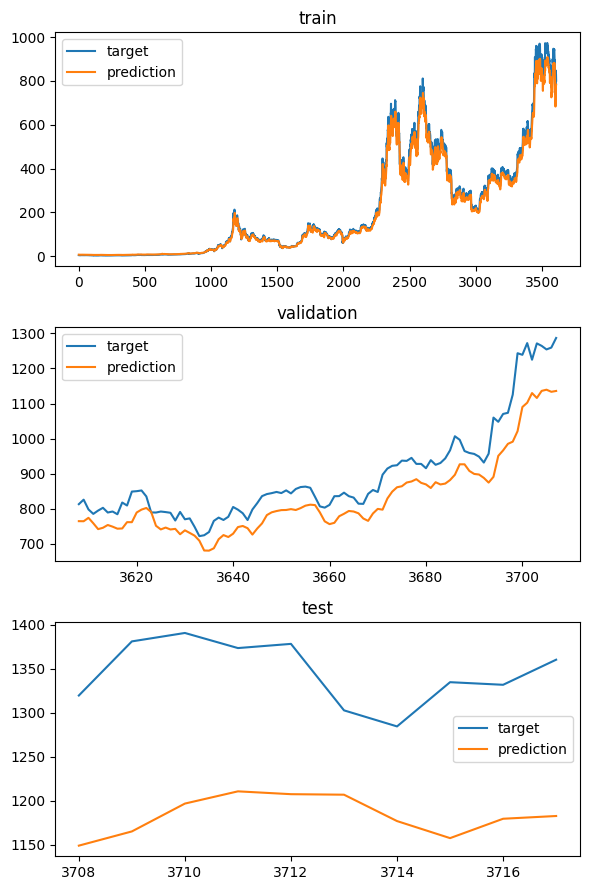

In [2]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path


BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 기준으로 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))

# 모델 정의 함수
def get_model(n_lstm_layers=2, n_linear_layers=1, dropout_rate=0.3):
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=n_lstm_layers, batch_first=True, dropout=dropout_rate)
            
            # 다중 Linear Layer 추가
            self.linear_layers = nn.Sequential(
                *[nn.Linear(128 if i == 0 else 64, 64 if i < n_linear_layers - 1 else n_output) for i in range(n_linear_layers)]
            )

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # x.shape: [batch_size, 128]
            x = self.linear_layers(x)
            return x

    return MyModel(n_input=5, n_output=1)

def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
        'n_lstm_layers': args.n_lstm_layers,
        'n_linear_layers': args.n_linear_layers,
        'dropout_rate': args.dropout_rate
  }

  project_name = "lstm_regression_btc_2-1_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  test_model = get_model(
        n_lstm_layers=args.n_lstm_layers,
        n_linear_layers=args.n_linear_layers,
        dropout_rate=args.dropout_rate
    )

  project_name = "lstm_regression_btc_2-1_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
    # 명령줄 인자 대신 Args 클래스를 사용
    class Args:
        wandb = True
        batch_size = 512
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 1e-3 # 0.0, 1e-5, 1e-4, 1e-3
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6
        n_lstm_layers = 1 # LSTM 레이어 개수 설정 기본 1 2, 3, 4
        n_linear_layers = 2  # Linear 레이어 개수 설정 기본 1,2 (3)
        dropout_rate = 0.0  # Dropout rate 설정 기본 0.1, 0.3, 0.5

    args = Args()
    wandb.finish()
    # 기존 main 함수에 args를 직접 전달
    main(args)

### [문제2] i_crypto_currency_classification_train_lstm.py

In [11]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 기준으로 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data

def get_model(n_input, n_output, lstm_layers=3, fc_layers=1, dropout_rate=0.0):
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()

            # LSTM 레이어 설정
            self.lstm = nn.LSTM(
                input_size=n_input, 
                hidden_size=256, 
                num_layers=lstm_layers, 
                batch_first=True, 
                dropout=dropout_rate if lstm_layers > 1 else 0.0
            )

            # FCN 레이어 설정
            fc_modules = []
            in_features = 256  # LSTM의 hidden_size

            for _ in range(fc_layers - 1):
                fc_modules.append(nn.Linear(in_features, in_features // 2))
                fc_modules.append(nn.ReLU())
                fc_modules.append(nn.Dropout(p=dropout_rate))
                in_features = in_features // 2

            fc_modules.append(nn.Linear(in_features, n_output))
            self.fcn = nn.Sequential(*fc_modules)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # 마지막 타임스텝의 출력만 사용
            x = self.fcn(x)
            return x

    return MyModel()

def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
        'dropout_rate': args.dropout_rate,
        'lstm_layers': args.lstm_layers,
        'fc_layers': args.fc_layers
    }

    project_name = "lstm_classification_btc_2-2_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="Tuning LSTM and FCN layers with dropout",
        tags=["lstm", "classification", "btc_krw", "tuning"],
        name=run_time_str,
        config=config
    )

    wandb.config.update({
        'weight_decay': args.weight_decay,
        'dropout_rate': args.dropout_rate,
        'lstm_layers': args.lstm_layers,
        'fc_layers': args.fc_layers
    }, allow_val_change=True)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model(
        n_input=5, 
        n_output=2, 
        lstm_layers=wandb.config.lstm_layers, 
        fc_layers=wandb.config.fc_layers, 
        dropout_rate=wandb.config.dropout_rate
    )
    model.to(device)

    optimizer = optim.Adam(
        model.parameters(), 
        lr=wandb.config.learning_rate, 
        weight_decay=wandb.config.weight_decay
    )

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()

if __name__ == "__main__":
    class Args:
        wandb = True
        batch_size = 1024
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 0.0
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6
        dropout_rate = 0.0
        lstm_layers = 2  # LSTM 레이어 증가
        fc_layers = 1  # FCN 레이어 증가
    wandb.finish()
    args = Args()
    main(args)


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.
[Epoch   1] T_loss: 0.69474, T_accuracy: 47.0371 | V_loss: 0.69453, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69124, T_accuracy: 53.3881 | V_loss: 0.69479, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69031, T_accuracy: 53.1897 | V_loss: 0.69353, V_accuracy: 47.3333 | V_loss decreased (0.69453 --> 0.69353). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69008, T_accuracy: 53.3314 | V_loss: 0.69431, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:05, T_speed: 18.000
[Epoch 120] T_loss: 0.69020, T_accuracy: 53.2180 | V_loss: 0.69337, V_accuracy: 49.3333 | V_loss decreased (0.69353 --> 0.69337). Saving model... | T_time: 00:00:07, T_speed: 17.143
[Epoch 150] T_loss: 0.69024, T_accuracy: 53.2180 | V_loss: 0.69369, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Training accuracy (%),▁▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█▇████
Training loss,█████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁
Training speed (epochs/sec.),▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▁▁▁▁▂▁▁▃▃▅▅▅▆▆▇▅▆▅▅▄▄▆▇▆▆▇▆▆▅▆▄▆▄▅▅▄▃▄▃█
Validation loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆█▇
Epoch,1200
Training accuracy (%),62.8296
Training loss,0.58316
Training speed (epochs/sec.),16.43836
Validation accuracy (%),62


### [문제2] j_crypto_currency_classification_test_lstm.py

In [40]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 기준으로 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
from _01_code._15_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model

def get_model_instance(n_input, n_output, lstm_layers, fc_layers, dropout_rate):
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()

            # LSTM 레이어 설정
            self.lstm = nn.LSTM(
                input_size=n_input, 
                hidden_size=256, 
                num_layers=lstm_layers, 
                batch_first=True, 
                dropout=dropout_rate if lstm_layers > 1 else 0.0
            )

            # FCN 레이어 설정
            fc_modules = []
            in_features = 256  # LSTM의 hidden_size

            for _ in range(fc_layers - 1):
                fc_modules.append(nn.Linear(in_features, in_features // 2))
                fc_modules.append(nn.ReLU())
                fc_modules.append(nn.Dropout(p=dropout_rate))
                in_features = in_features // 2

            fc_modules.append(nn.Linear(in_features, n_output))
            self.fcn = nn.Sequential(*fc_modules)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :] 
            x = self.fcn(x)
            return x

    return MyModel()

def test(test_model, n_input, n_output, lstm_layers, fc_layers, dropout_rate):
    _, _, test_data_loader = get_btc_krw_data(is_regression=False)

    test_model.eval()

    num_corrects_test = 0
    num_tested_samples = 0

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test)

            predicted_test = torch.argmax(output_test, dim=1)
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

            num_tested_samples += len(input_test)

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples

        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
                idx, torch.argmax(output).item(), target.item()
            ))

def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'lstm_layers': args.lstm_layers,
        'fc_layers': args.fc_layers,
        'dropout_rate': args.dropout_rate
    }

    project_name = "lstm_classification_btc_2-2_krw"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    test_model = get_model_instance(
        n_input=5, 
        n_output=2, 
        lstm_layers=config['lstm_layers'], 
        fc_layers=config['fc_layers'], 
        dropout_rate=config['dropout_rate']
    )

    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))

    test_model.load_state_dict(torch.load(latest_file_path))
    test_model.eval()

    test(
        test_model,
        n_input=5,
        n_output=2,
        lstm_layers=config['lstm_layers'],
        fc_layers=config['fc_layers'],
        dropout_rate=config['dropout_rate']
    )

if __name__ == "__main__":
    class Args:
        wandb = True
        batch_size = 512  # 최적의 배치 크기
        epochs = 10000  # 최대 에포크 수
        learning_rate = 1e-4  # 안정적인 학습을 위한 낮은 학습률
        weight_decay = 1e-4  # 과적합 방지
        validation_intervals = 30
        early_stop_patience = 30  # Early Stopping 빠르게 적용
        early_stop_delta = 1e-6
        lstm_layers = 2  # LSTM 레이어 수
        fc_layers = 1  # FCN 레이어 수
        dropout_rate = 0.0  # Dropout 비율

    args = Args()

    # 기존 main 함수에 args를 직접 전달
    main(args)

MODEL FILE: /home/work/HW4/checkpoints/lstm_classification_btc_2-2_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 70.000%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   0.00
 5:   1.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   0.00


# [문제 3]

### [문제3] g_crypto_currency_classification_train_lstm.py

In [10]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
import pandas as pd
from pathlib import Path

# 주피터 노트북 환경에 맞는 BASE_PATH 설정
BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 기준으로 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import CryptoCurrencyDataset


def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    btc_krw_path = os.path.join(BASE_PATH, "_00_data", "k_cryptocurrency", "BTC_KRW_NEXT.csv")
    df = pd.read_csv(btc_krw_path)
    row_size = len(df)
    # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NEXT_Open']
    date_list = df['Date']

    df = df.drop(columns=['Date'])

    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)
    #################################################################################################

    row_cursor = 0

    X_train_list = []
    y_train_regression_list = []
    y_train_classification_list = []
    y_train_date = []
    for idx in range(0, train_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_train_list.append(torch.from_numpy(sequence_data))
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_train_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    X_train = (X_train - m) / s

    #################################################################################################

    X_validation_list = []
    y_validation_regression_list = []
    y_validation_classification_list = []
    y_validation_date = []
    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_validation_list.append(torch.from_numpy(sequence_data))
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_validation_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_validation_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

    X_validation = (X_validation - m) / s
    #################################################################################################

    X_test_list = []
    y_test_regression_list = []
    y_test_classification_list = []
    y_test_date = []
    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_test_list.append(torch.from_numpy(sequence_data))
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_test_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

    X_test = (X_test - m) / s

    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date
        )

# 데이터 로딩 함수
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True, target_column='Close'):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = \
        get_cryptocurrency_data(
            sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
            target_column=target_column, y_normalizer=1.0e7, is_regression=is_regression
        )
    
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader


# 모델 정의 함수
def get_model(n_lstm_layers=2, n_linear_layers=1, dropout_rate=0.3):
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=n_lstm_layers, batch_first=True, dropout=dropout_rate)
            
            # 다중 Linear Layer 추가
            self.linear_layers = nn.Sequential(
                *[nn.Linear(128 if i == 0 else 64, 64 if i < n_linear_layers - 1 else n_output) for i in range(n_linear_layers)]
            )

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # x.shape: [batch_size, 128]
            x = self.linear_layers(x)
            return x

    return MyModel(n_input=6, n_output=1)

# 메인 학습 루프
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
        'n_lstm_layers': args.n_lstm_layers,
        'n_linear_layers': args.n_linear_layers,
        'dropout_rate': args.dropout_rate
    }

    print("Config before wandb.init:", config)

    project_name = "lstm_regression_btc_3-1_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="Experiment with LSTM layers and dropout",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )
    print(f"Wandb initialized: {wandb.run is not None}")
    print(f"Wandb mode: {wandb.run.mode if wandb.run else 'No run'}")
    print(f"Wandb URL: {wandb.run.url if wandb.run else 'No URL'}")

    # 수동 업데이트
    wandb.config.update({
        'weight_decay': args.weight_decay,
        'n_lstm_layers': args.n_lstm_layers,
        'n_linear_layers': args.n_linear_layers,
        'dropout_rate': args.dropout_rate
    }, allow_val_change=True)
    
    print(f"Wandb mode: {wandb.run.mode}")
    print("Wandb config after init:", wandb.config)

    # 두 가지 실행 케이스 처리
    for target_column in ["Next_Open", "Close"]:
        print(f"Running with target_column={target_column}")
        train_data_loader, validation_data_loader, _ = get_btc_krw_data(target_column=target_column)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Training on device {device}.")

        model = get_model(
            n_lstm_layers=wandb.config.n_lstm_layers,
            n_linear_layers=wandb.config.n_linear_layers,
            dropout_rate=wandb.config.dropout_rate
        )
        model.to(device)

        optimizer = optim.Adam(
            model.parameters(),
            lr=wandb.config.learning_rate,
            weight_decay=wandb.config.weight_decay
        )

        regression_trainer = RegressionTrainer(
            project_name, model, optimizer, train_data_loader, validation_data_loader, None,
            run_time_str, wandb, device, CHECKPOINT_FILE_PATH, target_column  # target_column 추가
        )
        regression_trainer.train_loop()

    wandb.finish()


if __name__ == "__main__":
    # 명령줄 인자 대신 Args 클래스를 사용
    class Args:
        wandb = True
        batch_size = 512
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 1e-3 # 0.0, 1e-5, 1e-4, 1e-3
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6
        n_lstm_layers = 1 # LSTM 레이어 개수 설정 기본 1 2, 3, 4
        n_linear_layers = 2  # Linear 레이어 개수 설정 기본 1,2 (3)
        dropout_rate = 0.0  # Dropout rate 설정 기본 0.1, 0.3, 0.5

    args = Args()
    wandb.finish()
    # 기존 main 함수에 args를 직접 전달
    main(args)


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▂▂▃▄▁▁▁▂▂▃█
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,6210
Training loss,0.01073
Training speed (epochs/sec.),102.3216
Validation loss,0.05214


Config before wandb.init: {'epochs': 10000, 'batch_size': 512, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.001, 'n_lstm_layers': 1, 'n_linear_layers': 2, 'dropout_rate': 0.0}


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Wandb initialized: True
Wandb mode: run
Wandb URL: https://wandb.ai/alstjr7141-korea-university-of-technology-and-education/lstm_regression_btc_3-1_krw/runs/u7xkoks2
Wandb mode: run
Wandb config after init: {'epochs': 10000, 'batch_size': 512, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.001, 'n_lstm_layers': 1, 'n_linear_layers': 2, 'dropout_rate': 0.0}
Running with target_column=Next_Open
Training on device cuda:0.


TypeError: RegressionTrainer.__init__() takes 11 positional arguments but 12 were given

### [문제3]  h_crypto_currency_classification_test_lstm.py

In [6]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 기준으로 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data


def test(test_model, target_column):
  _, _, test_data_loader = get_btc_krw_data(target_column=target_column)

  test_model.eval()

  y_normalizer = 100

  print(f"[TEST DATA] for target column: {target_column}")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))

# 모델 정의 함수
def get_model(n_lstm_layers=2, n_linear_layers=1, dropout_rate=0.3):
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=n_lstm_layers, batch_first=True, dropout=dropout_rate)
            
            # 다중 Linear Layer 추가
            self.linear_layers = nn.Sequential(
                *[nn.Linear(128 if i == 0 else 64, 64 if i < n_linear_layers - 1 else n_output) for i in range(n_linear_layers)]
            )

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # x.shape: [batch_size, 128]
            x = self.linear_layers(x)
            return x

    return MyModel(n_input=6, n_output=1)

def predict_all(test_model, target_column):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column=target_column, y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(f"{dataset_labels[i]} (Target: {target_column})")
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
        'n_lstm_layers': args.n_lstm_layers,
        'n_linear_layers': args.n_linear_layers,
        'dropout_rate': args.dropout_rate
  }

  project_name = "lstm_regression_btc_3-1_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  test_model = get_model(
        n_lstm_layers=args.n_lstm_layers,
        n_linear_layers=args.n_linear_layers,
        dropout_rate=args.dropout_rate
    )

  for target_column in ["Next_Open", "Close"]:
      print(f"Running tests for target_column: {target_column}")

      latest_file_path = os.path.join(
          CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest_{target_column}.pt"
      )
      print("MODEL FILE: {0}".format(latest_file_path))
      test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

      test(test_model, target_column)
      predict_all(test_model, target_column)

if __name__ == "__main__":
    # 명령줄 인자 대신 Args 클래스를 사용
    class Args:
        wandb = True
        batch_size = 512
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 1e-3 # 0.0, 1e-5, 1e-4, 1e-3
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6
        n_lstm_layers = 1 # LSTM 레이어 개수 설정 기본 1 2, 3, 4
        n_linear_layers = 2  # Linear 레이어 개수 설정 기본 1,2 (3)
        dropout_rate = 0.0  # Dropout rate 설정 기본 0.1, 0.3, 0.5

    args = Args()
    wandb.finish()
    # 기존 main 함수에 args를 직접 전달
    main(args)

Running tests for target_column: Next_Open
MODEL FILE: /home/work/HW4/checkpoints/lstm_regression_btc_3-1_krw_checkpoint_latest_Next_Open.pt


FileNotFoundError: [Errno 2] No such file or directory: '/home/work/HW4/checkpoints/lstm_regression_btc_3-1_krw_checkpoint_latest_Next_Open.pt'

### [문제3] i_crypto_currency_classification_train_lstm.py

In [10]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser

def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
  btc_krw_path = os.path.join(BASE_PATH, "_00_data", "k_cryptocurrency", "BTC_KRW_NEXT.csv")
  df = pd.read_csv(btc_krw_path)
  row_size = len(df)
  # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NEXT_Open']
  date_list = df['Date']

  df = df.drop(columns=['Date'])

  data_size = row_size - sequence_size
  train_size = data_size - (validation_size + test_size)
  #################################################################################################

  row_cursor = 0

  X_train_list = []
  y_train_regression_list = []
  y_train_classification_list = []
  y_train_date = []
  for idx in range(0, train_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_train_list.append(torch.from_numpy(sequence_data))
    y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_train_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_train_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_train = torch.stack(X_train_list, dim=0).to(torch.float)
  y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
  y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

  m = X_train.mean(dim=0, keepdim=True)
  s = X_train.std(dim=0, keepdim=True)
  X_train = (X_train - m) / s

  #################################################################################################

  X_validation_list = []
  y_validation_regression_list = []
  y_validation_classification_list = []
  y_validation_date = []
  for idx in range(row_cursor, row_cursor + validation_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_validation_list.append(torch.from_numpy(sequence_data))
    y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_validation_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_validation_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
  y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
  y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

  X_validation = (X_validation - m) / s
  #################################################################################################

  X_test_list = []
  y_test_regression_list = []
  y_test_classification_list = []
  y_test_date = []
  for idx in range(row_cursor, row_cursor + test_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_test_list.append(torch.from_numpy(sequence_data))
    y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_test_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_test_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_test = torch.stack(X_test_list, dim=0).to(torch.float)
  y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
  y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

  X_test = (X_test - m) / s

  if is_regression:
    return (
      X_train, X_validation, X_test,
      y_train_regression, y_validation_regression, y_test_regression,
      y_train_date, y_validation_date, y_test_date
    )
  else:
    return (
      X_train, X_validation, X_test,
      y_train_classification, y_validation_classification, y_test_classification,
      y_train_date, y_validation_date, y_test_date
    )

# 데이터 로딩 함수
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = \
        get_cryptocurrency_data(
            sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
            target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
        )
    
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader


def get_model(n_input, n_output, lstm_layers=3, fc_layers=1, dropout_rate=0.0):
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()

            # LSTM 레이어 설정
            self.lstm = nn.LSTM(
                input_size=n_input, 
                hidden_size=256, 
                num_layers=lstm_layers, 
                batch_first=True, 
                dropout=dropout_rate if lstm_layers > 1 else 0.0
            )

            fc_modules = []
            in_features = 256 

            for _ in range(fc_layers - 1):
                fc_modules.append(nn.Linear(in_features, in_features // 2))
                fc_modules.append(nn.ReLU())
                fc_modules.append(nn.Dropout(p=dropout_rate))
                in_features = in_features // 2

            fc_modules.append(nn.Linear(in_features, n_output))
            self.fcn = nn.Sequential(*fc_modules)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # 마지막 타임스텝의 출력만 사용
            x = self.fcn(x)
            return x

    return MyModel()

def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
        'dropout_rate': args.dropout_rate,
        'lstm_layers': args.lstm_layers,
        'fc_layers': args.fc_layers
    }

    project_name = "lstm_regression_btc_3-1_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="Tuning LSTM and FCN layers with dropout",
        tags=["lstm", "classification", "btc_krw", "tuning"],
        name=run_time_str,
        config=config
    )

    wandb.config.update({
        'weight_decay': args.weight_decay,
        'dropout_rate': args.dropout_rate,
        'lstm_layers': args.lstm_layers,
        'fc_layers': args.fc_layers
    }, allow_val_change=True)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model(
        n_input=5, 
        n_output=2, 
        lstm_layers=wandb.config.lstm_layers, 
        fc_layers=wandb.config.fc_layers, 
        dropout_rate=wandb.config.dropout_rate
    )
    model.to(device)

    optimizer = optim.Adam(
        model.parameters(), 
        lr=wandb.config.learning_rate, 
        weight_decay=wandb.config.weight_decay
    )

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()

if __name__ == "__main__":
    class Args:
        wandb = True
        batch_size = 1024
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 0.0
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6
        dropout_rate = 0.0
        lstm_layers = 2  # LSTM 레이어 증가
        fc_layers = 1  # FCN 레이어 증가
    wandb.finish()
    args = Args()
    main(args)


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.


RuntimeError: input.size(-1) must be equal to input_size. Expected 5, got 6

In [ ]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser

def get_model(n_input, n_output, lstm_layers=3, fc_layers=1, dropout_rate=0.0):
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()

            # LSTM 레이어 설정
            self.lstm = nn.LSTM(
                input_size=n_input, 
                hidden_size=256, 
                num_layers=lstm_layers, 
                batch_first=True, 
                dropout=dropout_rate if lstm_layers > 1 else 0.0
            )

            fc_modules = []
            in_features = 256 

            for _ in range(fc_layers - 1):
                fc_modules.append(nn.Linear(in_features, in_features // 2))
                fc_modules.append(nn.ReLU())
                fc_modules.append(nn.Dropout(p=dropout_rate))
                in_features = in_features // 2

            fc_modules.append(nn.Linear(in_features, n_output))
            self.fcn = nn.Sequential(*fc_modules)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # 마지막 타임스텝의 출력만 사용
            x = self.fcn(x)
            return x

    return MyModel()

def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
        'dropout_rate': args.dropout_rate,
        'lstm_layers': args.lstm_layers,
        'fc_layers': args.fc_layers
    }

    project_name = "lstm_regression_btc_3-1_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="Tuning LSTM and FCN layers with dropout",
        tags=["lstm", "classification", "btc_krw", "tuning"],
        name=run_time_str,
        config=config
    )

    wandb.config.update({
        'weight_decay': args.weight_decay,
        'dropout_rate': args.dropout_rate,
        'lstm_layers': args.lstm_layers,
        'fc_layers': args.fc_layers
    }, allow_val_change=True)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model(
        n_input=5, 
        n_output=2, 
        lstm_layers=wandb.config.lstm_layers, 
        fc_layers=wandb.config.fc_layers, 
        dropout_rate=wandb.config.dropout_rate
    )
    model.to(device)

    optimizer = optim.Adam(
        model.parameters(), 
        lr=wandb.config.learning_rate, 
        weight_decay=wandb.config.weight_decay
    )

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()

if __name__ == "__main__":
    class Args:
        wandb = True
        batch_size = 1024
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 0.0
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6
        dropout_rate = 0.0
        lstm_layers = 2  # LSTM 레이어 증가
        fc_layers = 1  # FCN 레이어 증가
    wandb.finish()
    args = Args()
    main(args)


### [문제3]  j_crypto_currency_classification_test_lstm.py

In [ ]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

BASE_PATH = os.getcwd()  # 현재 작업 디렉토리 기준으로 설정
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
from _01_code._15_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model

def get_model_instance(n_input, n_output, lstm_layers, fc_layers, dropout_rate):
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()

            # LSTM 레이어 설정
            self.lstm = nn.LSTM(
                input_size=n_input, 
                hidden_size=256, 
                num_layers=lstm_layers, 
                batch_first=True, 
                dropout=dropout_rate if lstm_layers > 1 else 0.0
            )

            # FCN 레이어 설정
            fc_modules = []
            in_features = 256  # LSTM의 hidden_size

            for _ in range(fc_layers - 1):
                fc_modules.append(nn.Linear(in_features, in_features // 2))
                fc_modules.append(nn.ReLU())
                fc_modules.append(nn.Dropout(p=dropout_rate))
                in_features = in_features // 2

            fc_modules.append(nn.Linear(in_features, n_output))
            self.fcn = nn.Sequential(*fc_modules)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # 마지막 타임스텝의 출력만 사용
            x = self.fcn(x)
            return x

    return MyModel()

def test(test_model, n_input, n_output, lstm_layers, fc_layers, dropout_rate):
    _, _, test_data_loader = get_btc_krw_data(is_regression=False)

    test_model.eval()

    num_corrects_test = 0
    num_tested_samples = 0

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test)

            predicted_test = torch.argmax(output_test, dim=1)
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

            num_tested_samples += len(input_test)

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples

        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
                idx, torch.argmax(output).item(), target.item()
            ))

def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'lstm_layers': args.lstm_layers,
        'fc_layers': args.fc_layers,
        'dropout_rate': args.dropout_rate
    }

    project_name = "lstm_classification_btc_3-2_krw"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    test_model = get_model_instance(
        n_input=5, 
        n_output=2, 
        lstm_layers=config['lstm_layers'], 
        fc_layers=config['fc_layers'], 
        dropout_rate=config['dropout_rate']
    )

    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))

    test_model.load_state_dict(torch.load(latest_file_path))
    test_model.eval()

    test(
        test_model,
        n_input=5,
        n_output=2,
        lstm_layers=config['lstm_layers'],
        fc_layers=config['fc_layers'],
        dropout_rate=config['dropout_rate']
    )

if __name__ == "__main__":
    # 명령줄 인자 대신 Args 클래스를 사용
    class Args:
        wandb = True
        batch_size = 512  # 최적의 배치 크기
        epochs = 10000  # 최대 에포크 수
        learning_rate = 1e-4  # 안정적인 학습을 위한 낮은 학습률
        weight_decay = 1e-4  # 과적합 방지
        validation_intervals = 30
        early_stop_patience = 30  # Early Stopping 빠르게 적용
        early_stop_delta = 1e-6
        lstm_layers = 2  # LSTM 레이어 수
        fc_layers = 1  # FCN 레이어 수
        dropout_rate = 0.0  # Dropout 비율

    args = Args()

    # 기존 main 함수에 args를 직접 전달
    main(args)

### 숙제 후기

너무 어려웠습니다... 2번도 겨우겨우 했는데 갑자기 3번이라는 벽이 생기더라고요... 2번을 끝낸 후 3번을 금방 할 줄 알았는데 Next_Open이라는 인자를 추가적으로 생성해서 해야하는데 솔직히 제가 일찍 시작하지 못한 탓에 끝낼 수 없었습니다.. 학습을 돌리는 시간이 너무 오래 걸려 금방금방 